In [25]:
# use hdf5 rather than .txt
# only for multi-threaded optimized
# output is also hdf5
# easy to use
# include diagnostic plot a. scatter pattern vs input scatter b SMF c. SHMR
import matplotlib
import numpy as np
import gzip
import sys
import os
import time
import matplotlib.pyplot as plt
from multiprocessing import Process
import multiprocessing
import h5py


In [26]:

#% matplotlib inline


# from scipy import integrate
# temp = np.genfromtxt("Ms_Mh_Vpeak.txt")
def _generic_open(f, buffering=100000000):
    """
    Returns
    -------
    fp : file handle
    need_to_close : bool
    """
    if hasattr(f, 'read'):
        return f, False
    else:
        if f.endswith('.gz'):
            fp = gzip.open(f, 'r')
        else:
            fp = open(f, 'r', int(buffering))
        return fp, True


def box_smooth(data_array):
    data_array = np.array(data_array)
    N = len(data_array)

    data_smooth = []

    for i in range(0, N):
        data_i = data_array[int(np.maximum(i - 1, 0)):int(np.minimum(i + 2, N))]
        # print(np.nanmean(data_i))

        data_smooth.append(np.nanmean(data_i))

    data_smooth = np.array(data_smooth).ravel()
    data_smooth[0] = np.nanmedian(data_array[:1])
    return data_smooth
inputs = sys.argv

try:
    parameters = open(str(inputs[1]), "r")
    print("We are using %s as parameter file"%inputs[1])
except:
    parameters = open("parameters.txt", "r")

count = 0
for line in parameters:
    if count == 1:
        file_name = line.replace("\n", "").split(" ")[0]
        box_size = float(line.replace("\n", "").split(" ")[1])
    if count == 3:
        halo_property = line.replace("\n", "").split(" ")[0]
    if count == 5:
        output_col = line.replace("\n", "").split(" ")
    if count == 7:
        SMF_fusion = np.genfromtxt(line.replace("\n", ""))
    if count == 9:
        scatter_fusion = np.genfromtxt(line.replace("\n", ""))
    if count==11:
        n_thread_max = int(line.replace("\n", "").split(" ")[0])
    count += 1

# read data

print("Reading data")
start_time = time.time()
hf = h5py.File(file_name,"r")

print("Keys in the input catalog")
hf.keys()


Reading data
Keys in the input catalog


<KeysViewHDF5 ['M_vir', 'Mpeak', 'V_max', 'Vpeak', 'dataset', 'header', 'id', 'pid', 'upid']>

In [27]:


x = np.log10(np.array(hf[halo_property]))
# calculate SMF_cumu:
# remember the returned SMF_cumu is not in log space:
#smf_combine = np.poly1d(np.polyfit(SMF_fusion[:,0], SMF_fusion[:,1], 10))

def calculate_abundance_smf(threshold):
    ans = 0
    dx=0.02
    N = int((14-threshold)/0.02)
    for i in range(N):
        ans+=10**np.interp(x=threshold+i*dx,xp =SMF_fusion[:,0],fp=np.log10(SMF_fusion[:,1]))*dx
    ans = ans*(0.7**3)
    return ans
calculate_abundance_smf = np.vectorize(calculate_abundance_smf)



y_target = SMF_fusion[:,0]
# modify y_target a little bit and
y_low = min(y_target)-(max(y_target)-min(y_target))
y_high = max(y_target)+(max(y_target)-min(y_target))
y_target = np.linspace(y_low,y_high,100)
SMF_cumu_target = calculate_abundance_smf(y_target)

# calculate number density
x_low = np.nanpercentile(x,0)
x_high = np.nanpercentile(x,100)
x_target = np.linspace(x_low,x_high,100)


V = box_size**3
x_num = []
for i in range(len(x_target)):
    mask_i = x>x_target[i]
    x_num.append(len(x[mask_i]))
x_num = np.array(x_num)
index_x_min = np.argmin(abs(x_target-x_low))
x_cumu_target = x_num/V
x_cumu = np.interp(x=x,xp=x_target,fp = x_cumu_target)

index_y = np.argsort(SMF_cumu_target)
y = np.interp(x=x_cumu,xp=SMF_cumu_target[index_y],fp=y_target[index_y])

# Remember to label y<SMF_fusion[:,0] as nan
mask = y<np.nanmin(SMF_fusion[:,0])
y[mask] = np.nan

# tabulating the data
# Here we got scatter of sigma[Ms|halo_properties]
# we tabulate scatter from 0 to 1 with 0.01 bin size:

if np.nanmedian(x_target)<5:
    upper_s = 0.4
else:
    upper_s = 1



In [28]:
## remember this sorted index_x since we also need to recover the hlist later
index_x = np.argsort(x)
x = x[index_x]
y = y[index_x]


In [29]:
# use one thread per numpy thread:
from multiprocessing import Process
import multiprocessing
import mkl
import warnings
mkl.set_num_threads(1)

# warning 
warnings.filterwarnings('ignore')

In [30]:
### Do some debugging
# scatter array target:
# Here we use 500 bins and use batch to do multi-threading
n_bins = 500
scatter_array_target = np.linspace(0, upper_s, n_bins)

# debugging:
#scatter_array_target=[0]

Vpeak_log = x
Vpeak_log_target = x_target
Ms_all_log = y
Ms_log_target = y_target
y_Ms_V_all = []
time_start = time.time()
print("Start tabulating scatter. may take 10-20 minutes. Grab a Coffee")

mask_finite = np.isfinite(x + y)
poly_Ms_from_halo = np.poly1d(np.polyfit(x[mask_finite], y[mask_finite], 10))

### use multithreading in tabulating the scatter:
#bin_size = len(scatter_array_target) // thread_to_use

my_pool = []

manager = multiprocessing.Manager()
final_results = manager.dict()



def helper(s):
 
    scatter = scatter_array_target[s]
    # print("start thread %d"%s)

    scatter_array_all = []

    properties_log_scatter = np.zeros(len(Vpeak_log))
    scatter_array_logMh = []
    ## Vpeak scatter to Mpeak:
    Vpeak_log_i = Vpeak_log + np.random.normal(0, scatter, len(Vpeak_log))

    index = np.argsort(Vpeak_log_i)
    Ms_all_log_s = Ms_all_log[index]

    y_Ms_at_Vpeak = []
    

    for m in range(0, len(Vpeak_log_target)):

        mask_V = (Vpeak_log > Vpeak_log_target[m] - 0.1 * upper_s) & (Vpeak_log < Vpeak_log_target[m] + 0.1 * upper_s)
        select_sample = Ms_all_log_s[mask_V] - poly_Ms_from_halo(Vpeak_log[mask_V])
        #select_sample = Ms_all_log_s[mask_V]
        # print(np.nanstd(select_sample))

        if len(select_sample)>20:
            y_Ms_at_Vpeak.append((np.nanpercentile(select_sample,84)-np.nanpercentile(select_sample,16))/2)
            # y_Ms_at_Vpeak.append(np.nanstd(select_sample))

        else:
            y_Ms_at_Vpeak.append(np.nan)

    # y_Ms_V_all.append(box_smooth(y_Ms_at_Vpeak))
    final_results[str(s)] = np.array(box_smooth(y_Ms_at_Vpeak))
    
# start threads:
# can split into several smaller batch
# n_thread_max= 24
n_batch = 1+n_bins//n_thread_max

"""
for ni in range(0, len(scatter_array_target)):
    pi = Process(target=helper, args=(ni,))
    my_pool.append(pi)
    pi.start()
    
for ni in range(0, len(scatter_array_target)):
    my_pool[ni].join()

"""
    
for bi in range(n_batch):
    print("Doing batch %d of %d"%(bi,n_batch))
    if bi<n_batch-1:
        for ni in range(n_thread_max*bi, n_thread_max*bi+n_thread_max):
            pi = Process(target=helper, args=(ni,))
            my_pool.append(pi)
            pi.start()

        for ni in range(n_thread_max*bi, n_thread_max*bi+n_thread_max):
            my_pool[ni].join()
    else:
        for ni in range(n_thread_max*bi, len(scatter_array_target)):
            pi = Process(target=helper, args=(ni,))
            my_pool.append(pi)
            pi.start()

        for ni in range(n_thread_max*bi, len(scatter_array_target)):
            my_pool[ni].join()
        
        

    
    
##Done
print("All threads done")


y_Ms_V_all = []
for i in range(0, len(scatter_array_target)):
    y_Ms_V_all.append(final_results[str(i)])

y_Ms_V_all = np.array(y_Ms_V_all)
print("Time we use for tabulating scatter %.2f seconds"%(time.time()-time_start))

# maybe we can save it :
np.savetxt("y_Ms_V_all.txt",y_Ms_V_all)




Start tabulating scatter. may take 10-20 minutes. Grab a Coffee
Doing batch 0 of 21
Doing batch 1 of 21
Doing batch 2 of 21
Doing batch 3 of 21
Doing batch 4 of 21
Doing batch 5 of 21
Doing batch 6 of 21
Doing batch 7 of 21
Doing batch 8 of 21
Doing batch 9 of 21
Doing batch 10 of 21
Doing batch 11 of 21
Doing batch 12 of 21
Doing batch 13 of 21
Doing batch 14 of 21
Doing batch 15 of 21
Doing batch 16 of 21
Doing batch 17 of 21
Doing batch 18 of 21
Doing batch 19 of 21
Doing batch 20 of 21
All threads done
Time we use for tabulating scatter 1074.23 seconds


In [31]:

# calculate the scatter for V
V_scatter = []
scatter_y_interp = np.interp(x=Ms_log_target,xp=scatter_fusion[:,0],fp=scatter_fusion[:,1])
for i in range(len(Vpeak_log_target)):
    index_min = np.argmin(abs(scatter_y_interp[i]-y_Ms_V_all[:,i]))
    #print(index_min,Vpeak_log_target[i])
    V_scatter.append(scatter_array_target[index_min])
V_scatter = np.array(V_scatter)

print("Done")

Done


In [32]:

print("Adding scatter and saving files")



### sort and recover:
## recovery:
index_recovery = np.argsort(index_x)


V_scatter_per_halo = np.random.normal(0,np.interp(x=x,xp=Vpeak_log_target,fp=V_scatter))

index_Vpeak_2 = np.argsort(x+V_scatter_per_halo)

Ms_all_log_sort_i = y[index_Vpeak_2]
# recover:
Ms_all_log_scatter = Ms_all_log_sort_i[index_recovery]

# output:
## remember only output Ms>lower limit of SMF_fusion
mask_effective = Ms_all_log_scatter<np.nanmin(SMF_fusion[:,0])
Ms_all_log_scatter[mask_effective]=None
"""


for o in range(len(output_col)):
    if o==0:
        fusion_output = np.array(hf[output_col[o]])
    else:
        fusion_output = np.c_[fusion_output,np.array(hf[output_col[o]])]
fusion_output = np.c_[fusion_output,Ms_all_log_scatter]     

# save it
np.savetxt("output.txt",fusion_output)



"""

# can also output hdf5

save = h5py.File("output.hdf5","w+")
for o in range(len(output_col)):
    save.create_dataset(output_col[o], data=np.array(hf[output_col[o]]), dtype="f")
save.create_dataset("Ms", data=Ms_all_log_scatter, dtype="f")
save.close()



Adding scatter and saving files


In [47]:
## Make diagnostic plots:
print("Making diagnostic plots")
# scatter patter:

font = {'family': 'normal','weight': 'bold',
        'size': 15}

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=3)


plt.plot(scatter_fusion[:,0],scatter_fusion[:,1],"ko",label="Original")
# calculate scatter for Ms at fixed halo property:
x_target = scatter_fusion[:,0]
bin_size= abs(np.nanmean(np.diff(x_target)))
y_scatter = []
x = np.log10(np.array(hf[halo_property]))
y_mean = []

for i in range(len(x_target)):
    mask_i = abs(x-x_target[i])<bin_size/2
    y_mean.append(np.nanmean(Ms_all_log_scatter[mask_i]))
y_mean = np.array(y_mean)

# fit poly
mask_finite = np.isfinite(x_target+y_mean)
#poly = np.poly1d(np.polyfit(x_target[mask_finite], y_mean[mask_finite], 5))

# calculate scatter:


def bootstrap_scatter_err(samples):
    mask_finite = np.isfinite(samples)
    samples = samples[mask_finite]
    index_all = range(len(samples))
    err_all = []
    N=100
    for i in range(0,N):
        index_choose = np.random.randint(0,len(samples)-1,len(samples))
        k_i = np.nanmedian(samples[index_choose])
        err_all.append(k_i)
    err_all = np.array(err_all)
    return err_all

y_scatter = []
y_scatter_err = []

for i in range(len(x_target)):
    mask_i = abs(x-x_target[i])<0.1 * upper_s
    #sample_select = Ms_all_log_scatter[mask_i]-poly(x[mask_i])
    sample_select = Ms_all_log_scatter[mask_i]-poly_Ms_from_halo(x[mask_i])
    mask_finite_i = np.isfinite(sample_select)
    sample_select = sample_select[mask_finite_i]
    if len(sample_select)>10:
        s_bigger = (np.percentile(sample_select, 84) - np.percentile(sample_select, 16)) / 2
        # s_bigger = np.nanstd(sample_select)
        y_scatter.append(s_bigger)
        y_scatter_err.append(np.nanstd(bootstrap_scatter_err(samples=sample_select)))
    else:
        y_scatter.append(np.nan)
        y_scatter_err.append(np.nan)
        
    


plt.errorbar(x=scatter_fusion[:,0],y=y_scatter,yerr=y_scatter_err,label="Calculated")
axes = plt.gca()
axes.set_ylim([0,upper_s])
plt.legend()
fig = matplotlib.pyplot.gcf()

fig.set_size_inches(9,9)
save_path = "scatter.pdf"

fig.savefig(save_path, dpi=150)

plt.close()

# SHMR:


font = {'family': 'normal','weight': 'bold',
        'size': 15}

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=3)



plt.plot(x_target,y_mean,"ko")
plt.xlabel("%s"%halo_property)
plt.ylabel("logMs")
plt.legend()
fig = matplotlib.pyplot.gcf()

fig.set_size_inches(9,9)
save_path = "SHMR.pdf"

fig.savefig(save_path, dpi=150)

plt.close()


# SMF:


font = {'family': 'normal','weight': 'bold',
        'size': 15}

matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=3)



plt.plot(SMF_fusion[:,0],np.log10(SMF_fusion[:,1]),"ko",label="Original")

# 
Ms_log_target = SMF_fusion[:,0]
y_smf = []
for mi in range(len(Ms_log_target)):
    mask_mi = abs(Ms_all_log_scatter-Ms_log_target[mi])<0.05
    y_smf.append(len(Ms_all_log_scatter[mask_mi]))
y_smf = np.array(y_smf)
y_smf_log = np.log10(y_smf)

mask_offset = (Ms_log_target>9.7)&(Ms_log_target<11.5)
offset = np.nanmean(np.log10(SMF_fusion[mask_offset,1]))-np.nanmean(y_smf_log[mask_offset])

plt.plot(SMF_fusion[:,0],y_smf_log+offset,"r",label="Calculated")


plt.xlabel("%s"%halo_property)
plt.ylabel(r"$\log \phi$")
plt.legend()

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(9,9)
save_path = "SMF.pdf"

fig.savefig(save_path, dpi=150)

plt.close()








Making diagnostic plots


No handles with labels found to put in legend.


In [48]:
print("All set!")

All set!


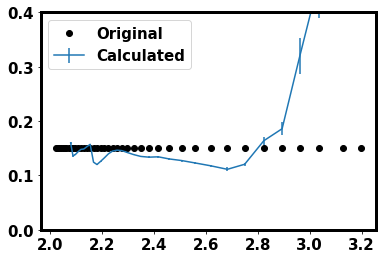

In [49]:
plt.errorbar(x=scatter_fusion[:,0],y=y_scatter,yerr=y_scatter_err,label="Calculated")
plt.plot(scatter_fusion[:,0],scatter_fusion[:,1],"ko",label="Original")
axes = plt.gca()
axes.set_ylim([0,upper_s])
plt.legend()

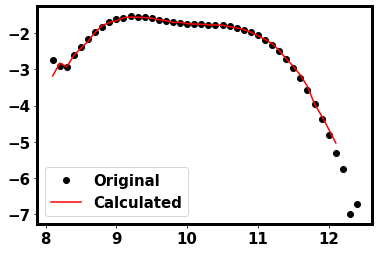

In [50]:
plt.plot(SMF_fusion[:,0],np.log10(SMF_fusion[:,1]),"ko",label="Original")

# 
Ms_log_target = SMF_fusion[:,0]
y_smf = []
for mi in range(len(Ms_log_target)):
    mask_mi = abs(Ms_all_log_scatter-Ms_log_target[mi])<0.05
    y_smf.append(len(Ms_all_log_scatter[mask_mi]))
y_smf = np.array(y_smf)
y_smf_log = np.log10(y_smf)

mask_offset = (Ms_log_target>9.7)&(Ms_log_target<11.5)
offset = np.nanmean(np.log10(SMF_fusion[mask_offset,1]))-np.nanmean(y_smf_log[mask_offset])

plt.plot(SMF_fusion[:,0],y_smf_log+offset,"r",label="Calculated")
plt.legend()